In [24]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%matplotlib inline
%aimport ichol_V
%aimport ichol
%aimport simulation
%aimport ichol_adadelta
%aimport ichol_constrain_m
%aimport cov_constrain_m
%aimport la
%aimport util
%aimport ichol_constrain_m2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [36]:
import os.path
from datetime import datetime
import numpy as np
from scipy import linalg
from pylab import *
from sklearn.decomposition.factor_analysis import FactorAnalysis

import ichol, ichol_V, ichol_adadelta, ichol_constrain_m, cov_constrain_m, ichol_constrain_m2
import simulation, la, util
from scipy.io import loadmat, savemat

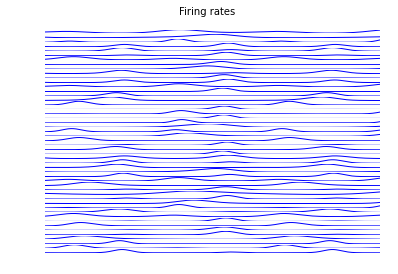

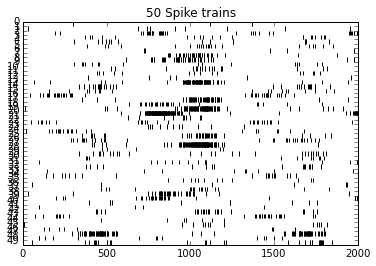

In [4]:
np.random.seed(0)

T = 2000
p = 0
L = 2
N = 50

high = np.log(25 / T)
low = np.log(5 / T)

# simulate latent processes
# x, ticks = simulation.latents(L, T, std, w)
x = np.empty((T, L), dtype=float)
# x[:T // 2, 0] = high
# x[T // 2:, 0] = low
# x[:, 1] = 2 * np.sin(np.linspace(0, 2 * np.pi * 5, T))
x[:, 0] = 2 * np.sin(0.005 * np.arange(T) + np.pi)
x[:, 1] = 2 * np.sin(0.01 * np.arange(T))

for l in range(L):
    x[:, l] -= np.mean(x[:, l])

# simulate spike trains
a = 2 * np.random.rand(L, N) - 1
for l in range(L):
    a[l, :] /= linalg.norm(a[l, :]) / np.sqrt(N)

b = np.empty((1 + p*N, N))
b[0, :] = low

y, _, rate = simulation.spikes(x, a, b, intercept=True)
figure()
_, ax = subplots(N, sharex=True)
for n in range(N):
    ax[n].plot(rate[:, n])
    ax[n].axis('off')
suptitle('Firing rates')

figure()
ylim(0, N)
for n in range(N):
    vlines(np.arange(T)[y[:, n] > 0], n, n + 1, color='black')
title('{} Spike trains'.format(N))
yticks(range(N))
gca().invert_yaxis()

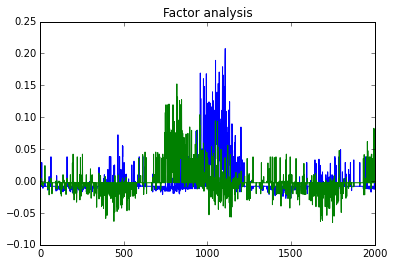

In [5]:
fa = FactorAnalysis(n_components=L)
m0 = fa.fit_transform(y)
a0 = fa.components_
# a0 = np.random.randn(L, N)
m0 *= np.linalg.norm(a0) / np.sqrt(N)
a0 /= np.linalg.norm(a0) / np.sqrt(N)

mu = np.zeros_like(x)

figure()
plot(m0)
title('Factor analysis')

In [8]:
bmask = np.full((1+N, N), fill_value=False, dtype=bool)

In [9]:
bmask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [10]:
bmask[0, :] = True
bmask[1:N+1, :] = np.eye(N, dtype=bool)

In [11]:
bmask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       ..., 
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]], dtype=bool)

In [40]:
grid = np.logspace(-6, -2, 5)

In [41]:
grid

array([  1.00000000e-06,   1.00000000e-05,   1.00000000e-04,
         1.00000000e-03,   1.00000000e-02])

In [52]:
chol_dict = {}

In [53]:
for w in grid:
    chol_dict[w] = la.ichol_gauss(T, w, 500)

/Users/yuan/variational/la.py:40: UserWarning: Not enough ranks
  warnings.warn('Not enough ranks')


In [54]:
chol_dict.keys()

dict_keys([1.0000000000000001e-05, 0.0001, 0.01, 9.9999999999999995e-07, 0.001])

In [45]:
chol = np.vstack((chol_dict[repr(1e-4)][np.newaxis, ...], chol_dict[repr(1e-5)][np.newaxis, ...]))

In [31]:
lbound, m1, a1, b1, elapsed, converged = ichol_constrain_m2.train(y, 0, chol=chol, a0=a0, b0=None, bmask=None, m0=m0, niter=50, tol=1e-5, verbose=True)


Iteration[1]
lower bound = -46378.92591
increment = 1200601.6397635920
time = 1.03s
change in a = 0.7101589089
change in b = 0.9980039982
change in m = 1.0081380060


Iteration[2]
lower bound = -19209.47633
increment = 27169.4495779856
time = 1.02s
change in a = 1.4961526595
change in b = 0.9945860273
change in m = 0.2198713631


Iteration[3]
lower bound = -11098.46167
increment = 8111.0146612275
time = 1.05s
change in a = 0.7142189791
change in b = 0.9853608886
change in m = 0.2860068806


Iteration[4]
lower bound = -8567.74039
increment = 2530.7212820932
time = 1.05s
change in a = 0.8350230154
change in b = 0.9607984150
change in m = 0.4274645008


Iteration[5]
lower bound = -7767.26122
increment = 800.4791694928
time = 1.07s
change in a = 1.0745349028
change in b = 0.8980570510
change in m = 0.4022817019


Iteration[6]
lower bound = -7525.56084
increment = 241.7003810697
time = 1.04s
change in a = 0.6085411796
change in b = 0.7576447537
change in m = 0.0827039280


Iteration[7]
low

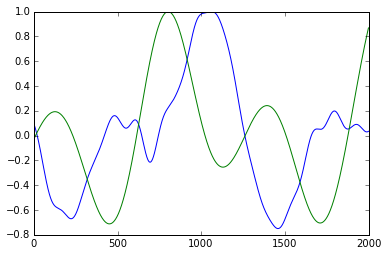

In [32]:
plot(m1)

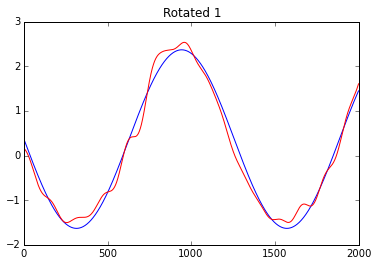

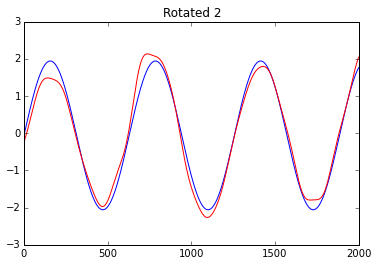

In [33]:
rotation = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, rotation)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='Latent', color='blue')
    plot(rotated[:, l], label='Rotated', color='red')
    title('Rotated {}'.format(l + 1))

In [51]:
savemat('data/chol', chol_dict)